In [1]:
import librosa
import IPython.display as display
import torch
from speechbrain.lobes.augment import EnvCorrupt as EnvCorrupt
from speechbrain.processing.speech_augmentation import AddNoise
from speechbrain.processing.speech_augmentation import SpeedPerturb
from speechbrain.processing.speech_augmentation import DropChunk
from datasets import load_dataset
from datasets import load_metric
import numpy as np

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, HubertForCTC

In [2]:
# dset = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
dset = load_dataset("kresnik/librispeech_asr_test", "clean")['test'].shuffle().select(np.arange(0, 200))
dset = dset.remove_columns(['speaker_id', 'chapter_id','id'])
wer_metric = load_metric("wer")

Reusing dataset librispeech_asr (/home-nfs/weizou/.cache/huggingface/datasets/kresnik___librispeech_asr/clean/2.1.0/16bc288fa237b20821c5b51c8c09426b2689d8c5a889287589cb12aba6705e74)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
w2v_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").cuda()

hubert_processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
hubert_model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").cuda()

def addnoise_noisy_decoding(batch, noise, model_type, noise_type):
    speech = batch["audio"]["array"]
    if noise_type == "white_noise":
        corrupter = AddNoise(mix_prob=noise)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
    elif noise_type == "speed_perturb":
        perturbator = SpeedPerturb(orig_freq=16000,speeds=[noise])
        corr = perturbator(torch.Tensor([speech]))
    elif noise_type == "drop_chunk_length":            
        corrupter = DropChunk(drop_length_low=noise, drop_length_high=noise, drop_count_low=100, drop_count_high=100)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
    elif noise_type == "drop_chunk_count":
        corrupter = DropChunk(drop_length_low=100, drop_length_high=100, drop_count_low=noise, drop_count_high=noise)
        corr = corrupter(torch.Tensor([speech]), torch.ones(1))
        
    if model_type == "wav2vec2":
        input_values = w2v_processor(np.array(corr[0]), sampling_rate=16000, return_tensors="pt", padding="longest").input_values
        input_values = input_values.to("cuda")
        with torch.no_grad():
            logits = w2v_model(input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        batch["pred_str"] = w2v_processor.batch_decode(pred_ids)[0]
        return batch
    elif model_type == "hubert":
        inputs = hubert_processor(np.array(corr[0]), sampling_rate=16000, return_tensors="pt")
        inputs = inputs.to("cuda")
        with torch.no_grad():
            logits = hubert_model(**inputs).logits
        pred_ids = torch.argmax(logits, dim=-1)
        batch["pred_str"] = hubert_processor.batch_decode(pred_ids)[0]
        return batch
    else:
        return None

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Noise type: white_noise
Model_type: wav2vec2


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.0, Test WER: 0.044


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.1, Test WER: 0.051


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.2, Test WER: 0.185


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.30000000000000004, Test WER: 0.233


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.4, Test WER: 0.315


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.5, Test WER: 0.337


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.6000000000000001, Test WER: 0.384


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.7000000000000001, Test WER: 0.502


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0.8, Test WER: 0.514


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 1.0, Test WER: 0.626
Model_type: hubert


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.0, Test WER: 0.028


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.1, Test WER: 0.032


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.2, Test WER: 0.054


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.30000000000000004, Test WER: 0.055


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.4, Test WER: 0.054


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.5, Test WER: 0.056
Model_type: hubert, Noise: 0.6000000000000001, Test WER: 0.073


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.7000000000000001, Test WER: 0.090


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.8, Test WER: 0.092


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0.9, Test WER: 0.097


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 1.0, Test WER: 0.103
Noise type: speed_perturb
Model_type: wav2vec2


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 50, Test WER: 0.954


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 75, Test WER: 0.066


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.044


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 125, Test WER: 0.047


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 150, Test WER: 0.215


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 175, Test WER: 0.748


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 0.955


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 225, Test WER: 0.980
Model_type: hubert


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 50, Test WER: 0.894


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 75, Test WER: 0.035


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 125, Test WER: 0.028


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 150, Test WER: 0.056


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 175, Test WER: 0.416


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 0.806


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 225, Test WER: 0.955
Noise type: drop_chunk_length
Model_type: wav2vec2


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 0, Test WER: 0.044


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.052


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 0.069


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 300, Test WER: 0.114


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 400, Test WER: 0.165


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 500, Test WER: 0.236


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 600, Test WER: 0.304


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 700, Test WER: 0.369


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 800, Test WER: 0.425


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 900, Test WER: 0.482


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 1000, Test WER: 0.534
Model_type: hubert


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 0, Test WER: 0.028


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 100, Test WER: 0.028


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 0.032


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 300, Test WER: 0.037


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 400, Test WER: 0.061


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 500, Test WER: 0.086


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 600, Test WER: 0.128


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 700, Test WER: 0.149


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 800, Test WER: 0.206


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 900, Test WER: 0.241


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 1000, Test WER: 0.294
Noise type: drop_chunk_count
Model_type: wav2vec2


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 100, Test WER: 0.049


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 200, Test WER: 0.084


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 300, Test WER: 0.155


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 400, Test WER: 0.254


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 500, Test WER: 0.347


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 600, Test WER: 0.441


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 700, Test WER: 0.517


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 800, Test WER: 0.589


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 900, Test WER: 0.645


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: wav2vec2, Noise: 1000, Test WER: 0.679
Model_type: hubert


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 100, Test WER: 0.030


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 200, Test WER: 0.032


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 300, Test WER: 0.043


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 400, Test WER: 0.057


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 500, Test WER: 0.085


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 600, Test WER: 0.112


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 700, Test WER: 0.150


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 800, Test WER: 0.191


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 900, Test WER: 0.235


  0%|          | 0/200 [00:00<?, ?ex/s]

Model_type: hubert, Noise: 1000, Test WER: 0.277


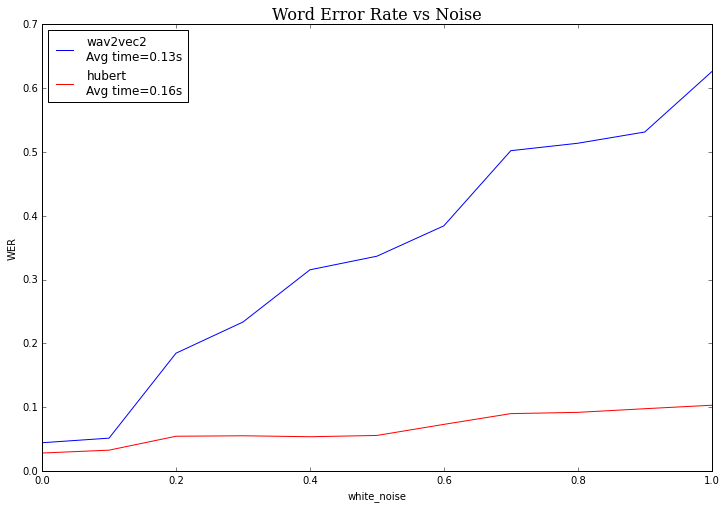

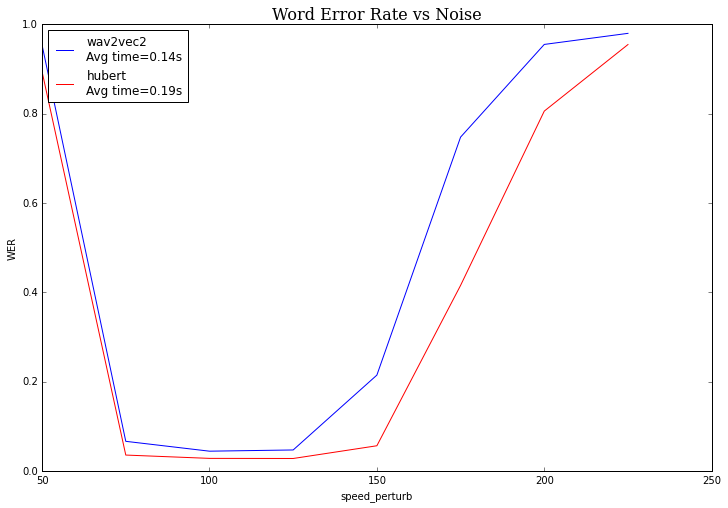

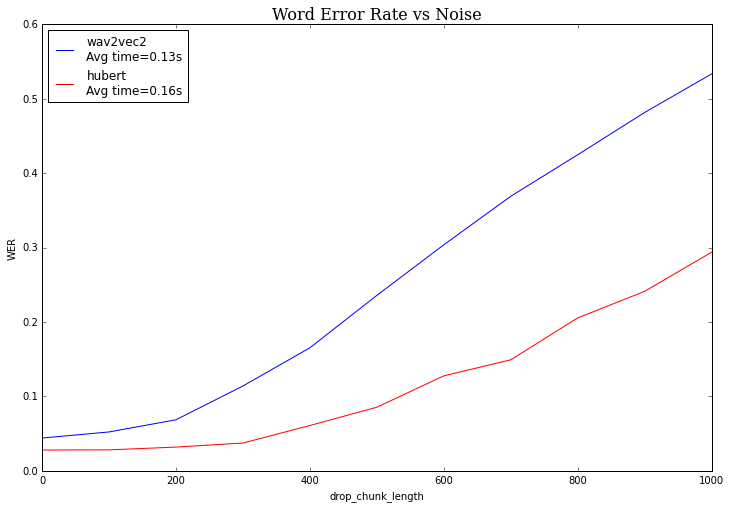

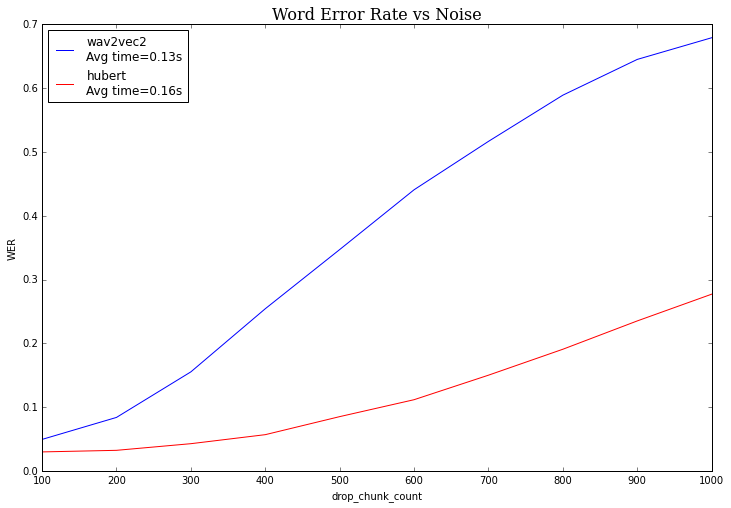

In [4]:
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
    
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

for noise_type in ["white_noise", "speed_perturb", "drop_chunk_length", "drop_chunk_count"]:
    print("Noise type:", noise_type)
    w2v_noises = []
    w2v_wers = []
    hubert_noises = []
    hubert_wers = []
    w2v_time = []
    hubert_time = []
    
    noise_list = []
    if noise_type == "white_noise":
        noise_list = np.arange(0, 1.1, .1)
    elif noise_type == "speed_perturb":
        noise_list = np.arange(50,250,25)
    elif noise_type == "drop_chunk_length":
        noise_list = np.arange(0,1100,100)
    elif noise_type == "drop_chunk_count":
        noise_list = np.arange(100,1100,100)
    else:
        assert(False)
        
    for model_type in ["wav2vec2", "hubert"]:
        print("Model_type:", model_type)
        for noise in noise_list:
            start_time = time.time()
            new_dset = dset.map(addnoise_noisy_decoding, 
                                fn_kwargs = {"noise": noise, "model_type": model_type, "noise_type" : noise_type}, 
                                batch_size = 1,
                                load_from_cache_file=False)
            tot_time = (time.time() - start_time) / len(dset)

            wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
            print("Model_type: {}, Noise: {}, Test WER: {:.3f}".format(model_type, noise, wer))
            if model_type == "wav2vec2":
                w2v_noises.append(noise)
                w2v_wers.append(wer)
                w2v_time.append(tot_time)
            else:
                hubert_noises.append(noise)
                hubert_wers.append(wer)
                hubert_time.append(tot_time)


    fig = plt.figure(figsize=(12, 8))
    w2vtime = np.round(np.mean(np.array(w2v_time)), 2)
    huberttime=np.round(np.mean(np.array(hubert_time)), 2)
    plt.plot(w2v_noises, w2v_wers, '-b', alpha=1, label='wav2vec2\nAvg time={}s'.format(w2vtime))
    plt.plot(hubert_noises, hubert_wers, '-r', alpha=1, label='hubert\nAvg time={}s'.format(huberttime))
    plt.legend(loc = 'upper left')
    plt.xlabel(noise_type)
    plt.ylabel("WER")
    plt.title("Word Error Rate vs Noise", fontsize=16, family='serif')
    plt.savefig('{}.pdf'.format(noise_type))
#     plt.show()

In [ ]:
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

w2v_addnoise_noises = []
w2v_addnoise_wers = []
w2v_time = []
    
for noise in np.arange(0, 1.1, .1):
    start_time = time.time()
    new_dset = dset.map(addnoise_noisy_decoding, 
                        fn_kwargs = {"noise": noise, "model_type": "wav2vec2", "noise_type" : "white_noise"}, 
                        batch_size = 1,
                        load_from_cache_file=False)
    w2v_time.append(time.time() - start_time)

    wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
    w2v_addnoise_noises.append(noise)
    w2v_addnoise_wers.append(wer)
    print("Noise: {}, Test WER: {:.3f}".format(noise, wer))

In [ ]:
hubert_addnoise_noises = []
hubert_addnoise_wers = []
hubert_time = []
    
for noise in np.arange(0, 1.1, .1):
    start_time = time.time()
    new_dset = dset.map(addnoise_noisy_decoding, 
                        fn_kwargs = {"noise": noise, "model_type": "hubert"},
                        batch_size = 1,
                        load_from_cache_file=False)
    
    hubert_time.append(time.time() - start_time)
    wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
    hubert_addnoise_noises.append(noise)
    hubert_addnoise_wers.append(wer)
    print("Noise: {}, Test WER: {:.3f}".format(noise, wer))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

fig = plt.figure(figsize=(12, 8))
w2vtime = np.round(np.mean(np.array(w2v_time)), 2)
# huberttime=np.round(np.mean(np.array(hubert_time)), 2)
plt.plot(w2v_addnoise_noises, w2v_addnoise_wers, '-b', alpha=1, label='wav2vec2\nAvg time={}s'.format(w2vtime))
# plt.plot(hubert_addnoise_noises, hubert_addnoise_wers, '-r', alpha=1, label='hubert\nAvg time={}s'.format(huberttime))
plt.legend(loc = 'upper left')
plt.xlabel("White Noise (ticks are stdevs)")
plt.ylabel("WER")
plt.title("Word Error Rate vs Noise", fontsize=16, family='serif')
# plt.savefig('whitenoise_libridummy.pdf')
plt.show()

In [ ]:
speedperturb_noises = []
speedperturb_wers = []
    
for noise in np.arange(50,250,20):
    new_dset = dset.map(addnoise_noisy_decoding, 
                        fn_kwargs = {"noise": noise, "model_type": "hubert", "noise_type" : "speed_perturb"}, 
                        batch_size = 1,
                        load_from_cache_file=False)

    wer = wer_metric.compute(predictions=new_dset["pred_str"], references=new_dset["text"])
    speedperturb_noises.append(noise)
    speedperturb_wers.append(wer)
    print("Noise: {}, Test WER: {:.3f}".format(noise, wer))